# Federated Learning for Diagnosis of Diabetes disease

The purpose of this notebook is to predict whether or not a patient has an diabatic condition, while also ensuring the privacy of the patient's health data through federated learning. 

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tarfile
import os

In [ ]:
tar = tarfile.open(os.path.join('/content/drive/MyDrive', 'archive.tar.xz'))
tar.extractall(path = '/content/drive/MyDrive/Data_Diab')

In [ ]:
dataDir = '/content/drive/MyDrive/Data_Diab/archive/diabetes.csv' 



In [ ]:
data = pd.read_csv(dataDir)
data.head()
data_copy = data


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import torch
from torch.autograd import Variable
import numpy as np

In [ ]:
d_new = np.array(data_copy)
y_data = d_new[:,-1]
y_data = pd.DataFrame(y_data)
y_data.head()

,0
0,1.0
1,0.0
2,1.0
3,0.0
4,1.0


In [ ]:
x_data = data.drop(['Outcome'], axis=1)
x_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_data = np.array(x_data)
x_data = sc.fit_transform(x_data)
x_data = pd.DataFrame(x_data)

x_data.head(5)


,0,1,2,3,4,5,6,7
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496


In [ ]:
data_new = pd.concat([x_data, y_data], axis=1)
data_new.head()

,0,1,2,3,4,5,6,7,0
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995,1.0
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672,0.0
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584,1.0
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549,0.0
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496,1.0


In [ ]:
data_new = np.array(data_new)
print(data_new)

[[ 0.63994726  0.84832379  0.14964075 ...  0.46849198  1.4259954
   1.        ]
 [-0.84488505 -1.12339636 -0.16054575 ... -0.36506078 -0.19067191
   0.        ]
 [ 1.23388019  1.94372388 -0.26394125 ...  0.60439732 -0.10558415
   1.        ]
 ...
 [ 0.3429808   0.00330087  0.14964075 ... -0.68519336 -0.27575966
   0.        ]
 [-0.84488505  0.1597866  -0.47073225 ... -0.37110101  1.17073215
   1.        ]
 [-0.84488505 -0.8730192   0.04624525 ... -0.47378505 -0.87137393
   0.        ]]


In [ ]:
print(data_new.shape)

(768, 9)


In [ ]:
def get_random_indexes(n):
    indexes = list(range(n))
    random_indexes = []
    for i in range(n):
        r = np.random.randint(len(indexes))
        random_indexes.append(indexes.pop(r))
    return random_indexes

def get_indexes_for_2_datasets(n, training = 80):
    indexes = get_random_indexes(n)
    train = int(training / 100. * n)
    return indexes[:train], indexes[train:]

matrix = data_new
n_samples, n_dimensions = matrix.shape

train_indexes, test_indexes = get_indexes_for_2_datasets(n_samples)
train_data = matrix[train_indexes]
test_data = matrix[test_indexes]

In [ ]:
print(train_data.shape)

(614, 9)


In [ ]:
print(test_data.shape)

(154, 9)


In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm as tqdm

input_size = 8
learning_rate = 0.001
num_iterations = 20000

class LogisticRegression(torch.nn.Module):

    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_size, 1)
        #self.l1 = torch.nn.Linear(8,6)
        #self.l2 = torch.nn.Linear(6,4)
        #self.l3 = torch.nn.Linear(4,2)
        #self.l4 = torch.nn.Linear(2,1)
        
        self.sigmoid = torch.nn.Sigmoid()
        #self.relu = torch.nn.ReLU()

    def forward(self, x):
        return torch.sigmoid(self.linear(x))
        #out1 = self.relu(self.l1(x))
        #out2 = self.relu(self.l2(out1))
        #out3 = self.relu(self.l3(out2))
        #prediction = self.sigmoid(self.l4(out3))
        #return prediction


In [ ]:
def decide(y):
    return 1. if y >= 0.5 else 0.

decide_vectorized = np.vectorize(decide)

to_percent = lambda x: '{:.2f}%'.format(x)




In [ ]:
def compute_accuracy(model, input, output):
    #print(input.shape, output.shape)
    prediction = model(input).detach().numpy()
    #print(prediction.shape)
    
    #n_samples = prediction.shape[0] + 0.
    prediction = decide_vectorized(prediction)
    equal = prediction.reshape(-1,) == output.detach().numpy().reshape(-1,)
    return 100. * np.mean(equal)



In [ ]:
def get_input_and_output(data):
    input = Variable(torch.tensor(data[:, :8], dtype = torch.float32))
    output1 = Variable(torch.tensor(data[:, 8], dtype = torch.float32))
    #output2 = Variable(torch.tensor(data[:, 7], dtype = torch.float32))
    return input, output1

input, output1 = get_input_and_output(train_data)
test_input, test_output1 = get_input_and_output(test_data)



In [ ]:
print(input.shape)

torch.Size([614, 8])


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

diagnosis_title = 'Diabetes'

def plot_graphs(diagnosis_title, losses, accuracies):
    plt.plot(losses)
    plt.title(f"{diagnosis_title} - Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")
    plt.show()
    plt.plot(accuracies)
    plt.title(f"{diagnosis_title} - Training Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy (Percent %)")
    plt.show()
    


In [ ]:
import torch.optim as optim

In [ ]:
def train_model(diagnosis_title, input, output, test_input, test_output):
    model = LogisticRegression()
    criterion = torch.nn.BCELoss(size_average=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  
    losses = []
    accuracies = []
    n_samples, _ = input.shape
    for iteration in tqdm(range(num_iterations)):
            optimizer.zero_grad()
            prediction = model(input)
            #print(prediction.size(), output.size())
            loss = criterion(prediction, output)
            loss.backward()
            optimizer.step()
            if iteration % 500 == 0:
            
                train_acc = compute_accuracy(model, input, output)
                train_loss = loss.item()
                losses.append(train_loss)
                accuracies.append(train_acc)
                print('iteration={}, loss={:.4f}, train_acc={}'.format(iteration, train_loss, to_percent(train_acc)))
            #scheduler.step()
    plot_graphs(diagnosis_title, losses, accuracies)
    test_acc = compute_accuracy(model, test_input, test_output)
    print('\nTesting Accuracy = {}'.format(to_percent(test_acc)))
    return model

  2%|▏         | 352/20000 [00:00<00:11, 1761.29it/s]

iteration=0, loss=0.8745, train_acc=34.85%


  3%|▎         | 687/20000 [00:00<00:11, 1719.72it/s]

iteration=500, loss=0.7634, train_acc=46.58%


  6%|▌         | 1198/20000 [00:00<00:11, 1708.51it/s]

iteration=1000, loss=0.6858, train_acc=56.51%


  9%|▊         | 1705/20000 [00:01<00:10, 1695.56it/s]

iteration=1500, loss=0.6321, train_acc=63.36%


 11%|█         | 2195/20000 [00:01<00:11, 1611.30it/s]

iteration=2000, loss=0.5945, train_acc=69.06%


 13%|█▎        | 2696/20000 [00:01<00:10, 1651.68it/s]

iteration=2500, loss=0.5676, train_acc=72.31%


 16%|█▌        | 3208/20000 [00:01<00:09, 1682.40it/s]

iteration=3000, loss=0.5477, train_acc=74.92%


 19%|█▊        | 3711/20000 [00:02<00:09, 1653.94it/s]

iteration=3500, loss=0.5328, train_acc=75.24%


 21%|██        | 4208/20000 [00:02<00:09, 1631.93it/s]

iteration=4000, loss=0.5212, train_acc=75.08%


 24%|██▎       | 4710/20000 [00:02<00:09, 1642.99it/s]

iteration=4500, loss=0.5120, train_acc=75.90%


 26%|██▌       | 5216/20000 [00:03<00:08, 1666.11it/s]

iteration=5000, loss=0.5046, train_acc=76.22%


 29%|██▊       | 5714/20000 [00:03<00:08, 1627.07it/s]

iteration=5500, loss=0.4986, train_acc=76.55%


 31%|███       | 6215/20000 [00:03<00:08, 1651.92it/s]

iteration=6000, loss=0.4935, train_acc=77.36%


 34%|███▎      | 6719/20000 [00:04<00:08, 1657.85it/s]

iteration=6500, loss=0.4893, train_acc=77.85%


 36%|███▌      | 7229/20000 [00:04<00:07, 1663.05it/s]

iteration=7000, loss=0.4857, train_acc=78.01%


 39%|███▊      | 7737/20000 [00:04<00:07, 1667.19it/s]

iteration=7500, loss=0.4827, train_acc=78.01%


 41%|████      | 8245/20000 [00:04<00:07, 1668.47it/s]

iteration=8000, loss=0.4800, train_acc=77.69%


 44%|████▍     | 8752/20000 [00:05<00:06, 1673.98it/s]

iteration=8500, loss=0.4777, train_acc=77.69%


 46%|████▌     | 9247/20000 [00:05<00:06, 1604.91it/s]

iteration=9000, loss=0.4757, train_acc=77.85%


 49%|████▉     | 9756/20000 [00:05<00:06, 1663.98it/s]

iteration=9500, loss=0.4740, train_acc=78.01%


 51%|█████▏    | 10263/20000 [00:06<00:05, 1673.58it/s]

iteration=10000, loss=0.4724, train_acc=77.85%


 54%|█████▍    | 10770/20000 [00:06<00:05, 1663.32it/s]

iteration=10500, loss=0.4711, train_acc=77.85%


 56%|█████▋    | 11292/20000 [00:06<00:05, 1701.40it/s]

iteration=11000, loss=0.4698, train_acc=78.01%


 59%|█████▉    | 11812/20000 [00:07<00:04, 1693.10it/s]

iteration=11500, loss=0.4688, train_acc=77.85%


 62%|██████▏   | 12325/20000 [00:07<00:04, 1690.46it/s]

iteration=12000, loss=0.4678, train_acc=77.85%


 64%|██████▍   | 12840/20000 [00:07<00:04, 1684.88it/s]

iteration=12500, loss=0.4669, train_acc=78.01%


 66%|██████▌   | 13178/20000 [00:07<00:04, 1647.07it/s]

iteration=13000, loss=0.4662, train_acc=78.18%


 68%|██████▊   | 13687/20000 [00:08<00:03, 1673.79it/s]

iteration=13500, loss=0.4655, train_acc=78.01%


 71%|███████   | 14191/20000 [00:08<00:03, 1649.06it/s]

iteration=14000, loss=0.4648, train_acc=78.01%


 73%|███████▎  | 14697/20000 [00:08<00:03, 1648.77it/s]

iteration=14500, loss=0.4643, train_acc=78.01%


 76%|███████▌  | 15200/20000 [00:09<00:02, 1663.98it/s]

iteration=15000, loss=0.4638, train_acc=78.01%


 79%|███████▊  | 15702/20000 [00:09<00:02, 1642.12it/s]

iteration=15500, loss=0.4633, train_acc=78.01%


 81%|████████  | 16205/20000 [00:09<00:02, 1649.31it/s]

iteration=16000, loss=0.4629, train_acc=78.01%


 84%|████████▎ | 16705/20000 [00:10<00:02, 1642.53it/s]

iteration=16500, loss=0.4625, train_acc=78.01%


 86%|████████▌ | 17199/20000 [00:10<00:01, 1621.25it/s]

iteration=17000, loss=0.4621, train_acc=78.01%


 89%|████████▊ | 17701/20000 [00:10<00:01, 1644.88it/s]

iteration=17500, loss=0.4618, train_acc=78.01%


 91%|█████████ | 18209/20000 [00:11<00:01, 1618.67it/s]

iteration=18000, loss=0.4615, train_acc=78.01%


 94%|█████████▎| 18720/20000 [00:11<00:00, 1677.90it/s]

iteration=18500, loss=0.4613, train_acc=78.01%


 96%|█████████▌| 19227/20000 [00:11<00:00, 1650.73it/s]

iteration=19000, loss=0.4610, train_acc=78.01%


 99%|█████████▊| 19731/20000 [00:11<00:00, 1617.11it/s]

iteration=19500, loss=0.4608, train_acc=78.01%


100%|██████████| 20000/20000 [00:12<00:00, 1652.59it/s]


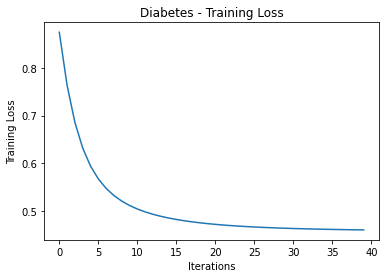

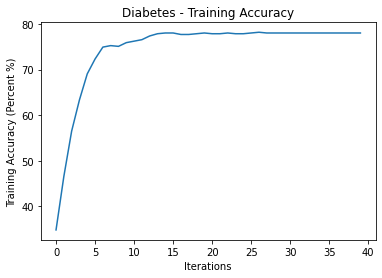


Testing Accuracy = 74.03%


In [ ]:
model = train_model(diagnosis_title, input, output1.view(-1,1), test_input, test_output1)

## Implementing Federated Learning with FedAvg Algorithm

In [ ]:
assert True is True

In [ ]:
!pip install syft=="0.2.2a1"
!pip install syft_proto=="0.1.1a1.post17"

     |████████████████████████████████| 337kB 33.2MB/s 
     |████████████████████████████████| 10.2MB 29.6MB/s 
     |████████████████████████████████| 773.1MB 23kB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
     |████████████████████████████████| 532kB 56.0MB/s 
     |████████████████████████████████| 2.1MB 37.6MB/s 
     |████████████████████████████████| 1.8MB 32.4MB/s 
     |████████████████████████████████| 112kB 55.3MB/s 
     |████████████████████████████████| 61kB 10.6MB/s 
     |████████████████████████████████| 61kB 10.3MB/s 
  Created wheel for phe: filename=phe-1.4.0-py2.py3-none-any.whl size=37362 sha256=0ec0dbcac49312ab9dcbbc78fdf29baca9be80104a800d96b3bbb78868fb63ae
  Stored in directory: /root/.cache/pip/wheels/f8/dc/36/dcb6bf0f1b9907e7b710ace63e64d08e7022340909315fdea4
  Created wheel for zstd: filename=zstd-1.5.0.2-cp37-cp37m-linux_x86_64.whl size=1672604 sha256=189c3809acb12e60c695b913fbef305608c5

     |████████████████████████████████| 40kB 6.0MB/s 
  Found existing installation: syft-proto 0.5.3
    Uninstalling syft-proto-0.5.3:
      Successfully uninstalled syft-proto-0.5.3


In [ ]:
import sys
import pytest
import syft as sy

In [ ]:
import torch as th
hook = sy.TorchHook(th)
from torch import nn, optim

In [ ]:
n_hospitals = 2
hospitals = []
for i in range(n_hospitals):
    hospital_name = 'hospital{}'.format(i)
    hospital = sy.VirtualWorker(hook, id = hospital_name)
    hospitals.append(hospital)
secure_worker = sy.VirtualWorker(hook, id="secure_worker")

In [ ]:
def get_workers_names(workers):
    return [worker.id for worker in workers]

In [ ]:
def add_and_print_workers(worker, workers):
    print('workers of {} = {}'.format(worker.id, get_workers_names(workers)))
    worker.add_workers(workers)

In [ ]:
for i in range(n_hospitals):
    workers = [hospitals[i2] for i2 in range(n_hospitals) if i2 != i] + [secure_worker]
    add_and_print_workers(hospitals[i], workers)
add_and_print_workers(secure_worker, hospitals)

workers of hospital0 = ['hospital1', 'secure_worker']
workers of hospital1 = ['hospital0', 'secure_worker']
workers of secure_worker = ['hospital0', 'hospital1']


In [ ]:
n_samples = train_data.shape[0]
samples_per_hospital = int((n_samples + 0.5) / n_hospitals)
hospital_features = []
hospital_targets1 = []
#hospital_targets2 = []
train_data = th.tensor(train_data, dtype = torch.float32, requires_grad=True)
for i in range(n_hospitals):
    train_data2 = train_data[i * samples_per_hospital:(i + 1) * samples_per_hospital].clone().detach().requires_grad_(True)
    features = train_data2[:, :8].clone().detach().requires_grad_(True)
    targets1 = train_data2[:, 8][:, None].clone().detach() 
    #targets2 = train_data2[:, 7][:, None].clone().detach() 
    hospital_features.append(features.send(hospitals[i]))
    hospital_targets1.append(targets1.send(hospitals[i]))
    #hospital_targets2.append(targets2.send(hospitals[i]))

print(model)

LogisticRegression(
  (linear): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
def plot_federated_graphs(diagnosis_title, losses, accuracies):
    for i in range(n_hospitals):
        plt.plot(losses[i], label=f'Hospital {i}')
    legend = plt.legend(loc='upper right', shadow=True)
    plt.title(f"{diagnosis_title} - Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")
    plt.show()
    for i in range(n_hospitals):
        plt.plot(accuracies[i], label=f'Hospital {i}')
    legend = plt.legend(loc='lower right', shadow=True)
    plt.title(f"{diagnosis_title} - Training Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy (%)")
    plt.show()
    

In [ ]:
def compute_federated_accuracy(model, input, output):
    prediction = model(input)
    n_samples = prediction.shape[0]
    s = 0.
    for i in range(n_samples):
        p = 1. if prediction[i] >= 0.5 else 0.
        e = 1. if p == output[i] else 0.
        s += e
    return 100. * s / n_samples


In [ ]:
iterations = 700 #2000
worker_iterations = 10

def federated_learning(diagnosis_title, hospital_features, hospital_targets, test_input, test_output):
    model = LogisticRegression()
    criterion = torch.nn.BCELoss(size_average=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    losses = [[] for i in range(n_hospitals)]
    accuracies = [[] for i in range(n_hospitals)]
    for iteration in range(iterations):
        models = [model.copy().send(hospitals[i]) for i in range(n_hospitals)]
        optimizers = [torch.optim.SGD(params = models[i].parameters(), lr = learning_rate) for i in range(n_hospitals)]
        for worker_iteration in range(worker_iterations):
            last_losses = []
            for i in range(n_hospitals):
                optimizers[i].zero_grad()
                prediction = models[i](hospital_features[i])
                loss = criterion(prediction, hospital_targets[i])
                loss.backward()
                optimizers[i].step()
                loss = loss.get().data.item()
                last_losses.append(loss)
        for i in range(n_hospitals):
            losses[i].append(last_losses[i])
            train_acc = compute_federated_accuracy(models[i], hospital_features[i], hospital_targets[i])
            accuracies[i].append(train_acc)
            models[i].move(secure_worker)
        with th.no_grad():
            avg_weight = sum([models[i].linear.weight.data for i in range(n_hospitals)]) / n_hospitals
            model.linear.weight.set_(avg_weight.get())
            avg_bias = sum([models[i].linear.bias.data for i in range(n_hospitals)]) / n_hospitals
            model.linear.bias.set_(avg_bias.get())
        if iteration % 100 == 0:
            losses_str = ['{:.4f}'.format(losses[i][-1]) for i in range(n_hospitals)]
            accuracies_str = [to_percent(accuracies[i][-1]) for i in range(n_hospitals)]
            print('Iteration={}, losses={}, accuracies={}'.format(iteration, losses_str, accuracies_str))
    plot_federated_graphs(diagnosis_title, losses, accuracies)
    test_acc = compute_accuracy(model, test_input, test_output)
    print('\nTesting Accuracy = {}'.format(to_percent(test_acc)))
    return model

Iteration=0, losses=['0.7292', '0.7820'], accuracies=['44.30%', '37.13%']
Iteration=100, losses=['0.6242', '0.6590'], accuracies=['65.80%', '59.28%']
Iteration=200, losses=['0.5690', '0.5905'], accuracies=['72.96%', '67.75%']
Iteration=300, losses=['0.5373', '0.5492'], accuracies=['75.90%', '71.01%']
Iteration=400, losses=['0.5176', '0.5228'], accuracies=['76.22%', '74.59%']
Iteration=500, losses=['0.5045', '0.5049'], accuracies=['76.22%', '76.87%']
Iteration=600, losses=['0.4955', '0.4923'], accuracies=['76.22%', '77.85%']


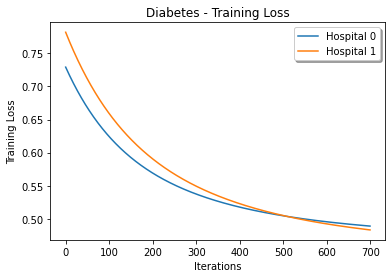

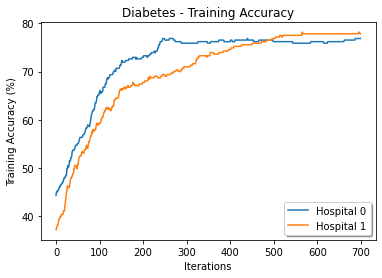


Testing Accuracy = 75.32%


In [ ]:
model = federated_learning(diagnosis_title, hospital_features, hospital_targets1, test_input, test_output1)